### Loading data

Below we have the code that retrieves the data from the  Mechanical Turk Tracker Demographics API.

In [13]:
print("{x:1.0f}".format(x=0.51))

1


In [6]:
round(1.5)

2

In [7]:
round(2.5)

2

In [8]:
round(3.5)

4

In [1]:
import pandas as pd
df = pd.read_csv("mturk_surveys_extended.csv")
df.drop(df.columns[0], axis=1, inplace=True) # drop the "index" column
# We now transform our API answer into a flat table
# and set the right data types
df["hit_answered_date"]=pd.to_datetime(df["hit_answered_date"])
df["hit_creation_date"]=pd.to_datetime(df["hit_creation_date"])
df["household_income"]=df["household_income"].astype("category")
df["household_size"]=df["household_size"].astype("category")
df["location_country"]=df["location_country"].astype("category")
df["marital_status"]=df["marital_status"].astype("category")
df['date'] = df['hit_answered_date'].apply(lambda x : x.date())
df['time'] = df['hit_answered_date'].apply(lambda x : x.time())
df.dtypes

educational_level                   object
gender                              object
hit_answered_date           datetime64[ns]
hit_creation_date           datetime64[ns]
household_income                  category
household_size                    category
languages_spoken                    object
location_city                       object
location_country                  category
location_region                     object
marital_status                    category
post_to_completion_secs            float64
time_spent_on_mturk                 object
weekly_income_from_mturk            object
worker_id                           object
year_of_birth                        int64
date                                object
time                                object
dtype: object

In [2]:
import datetime
minDate = min(df['hit_answered_date'])
maxDate = max(df['hit_answered_date'])
days = (maxDate - minDate).days
print(minDate)
print(maxDate)
print(days)

2015-03-26 11:47:28.877000
2018-01-10 20:28:40.525000
1021


In [3]:
from time import gmtime, strftime
def t():
    print(strftime("%Y-%m-%d %H:%M:%S", gmtime()))
    

In [4]:
df.head(5)

,educational_level,gender,hit_answered_date,hit_creation_date,household_income,household_size,languages_spoken,location_city,location_country,location_region,marital_status,post_to_completion_secs,time_spent_on_mturk,weekly_income_from_mturk,worker_id,year_of_birth,date,time
0,Bachelors degree,female,2018-01-10 20:28:40.525,2018-01-10 20:27:12,"$40,000-$59,999",1,English,killeen,US,tx,single,88.0,4-8 hours per week,$1-$5 per week,e194c2bac84948e0e9060ff0157dd59d,1989,2018-01-10,20:28:40.525000
1,"Some college, no degree",female,2018-01-10 20:20:45.463,2018-01-10 20:12:11,"$40,000-$59,999",4,English,denver,US,co,married,514.0,4-8 hours per week,$10-$20 per week,f406ad4e7a7ecd57023f975f3549def2,1984,2018-01-10,20:20:45.463000
2,"Graduate degree, Masters",female,2018-01-10 20:01:29.094,2018-01-10 19:57:12,"$100,000 or more",5+,English,omaha,US,ne,married,257.0,8-20 hours per week,$50-$100 per week,01ecbbbf603a9784f8426811d20abe0c,1975,2018-01-10,20:01:29.094000
3,Bachelors degree,female,2018-01-10 19:49:31.752,2018-01-10 19:42:12,"$40,000-$59,999",2,English,powell,US,oh,married,439.0,20-40 hours per week,$10-$20 per week,eaeb7e00d369241f9e700f3c4b18b958,1950,2018-01-10,19:49:31.752000
4,Associates degree,female,2018-01-10 19:28:38.262,2018-01-10 19:27:12,"$40,000-$59,999",2,English,high springs,US,fl,married,86.0,4-8 hours per week,$5-$10 per week,7cbaecb10cc3b8e6aa5ea2928661efee,1974,2018-01-10,19:28:38.262000


### Exploratory plots

In [5]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc("figure", figsize=(16, 8))
mpl.rcParams.update({'font.size': 22})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")

### Capture Recapture model

We will now attempt to estimate the capture-recapture models in order to estimate the overall population size of MTurk workers.

#### Two-occasion Model (Lincoln Estimator)


We will start with the simplest models first, expanding to more complex approaches later:

This model assumes that we have two samples (the "capture" and the "recapture").

In the first sampling period we "capture" (i.e., survey) $n_1$ workers from the population and we mark them as captured. 

In the second sampling period we "capture" $n_2$ workers. 

We assume that:
* None of the workers from the first period have left (no "deaths"). This means that we have $n_1$ marked workers in the population in the second sampling period. 
* The probabiliy of capturing each worker is uniform in the population of workers.
* That the size of the population $N$ in the second sampling period is significantly higher than $n_1$ and $n_2$, so that the probability of probability of "recapturing" a worker in every sampling attempt is $n_1 / N$. This allows us to use a d 

If the population during the recapture period is $N$, then when we pick a worker at random, the probability of "recapturing" a "captured" worker is $n_1 / N$. Therefore, when we sample $n_2$ workers, on expectation, we will have $E[m] = \frac{n_1 \cdot n_2}{N}$ common workers in the two samples. So, if we have $m$ common workers, we have that $m \approx \frac{n_1 \cdot n_2}{N}$ and therefore $N \approx \frac{n_1 \cdot n_2}{m}$.

In [6]:
def getWorkerIDs(df, startDate, endDate):
    '''
    Returns the set of distinct workers that participated in the surveys between the two dates
    '''
    return set(df["worker_id"][(df['hit_answered_date']>=startDate) & (df['hit_answered_date']<endDate)])


In [7]:
import numpy as np

def capture_recapture_lincoln_estimator(df, groupAstart, groupBstart, window):
    groupAend = groupAstart + datetime.timedelta(days=window)
    groupBend = groupBstart + datetime.timedelta(days=window)
    workersA = getWorkerIDs(df, groupAstart, groupAend)
    workersB = getWorkerIDs(df, groupBstart, groupBend)
    union = workersA | workersB
    intersection = workersA & workersB
    if len(intersection) > 0:
        capture_recapture_estimate = len(workersA) * len(workersB) / len(intersection)
        y = np.log(capture_recapture_estimate)
    else:
        capture_recapture_estimate = None
        y = None

    return {
        "window" : window,
        "groupA_start" : groupAstart,
        "groupA_end" : groupAend,
        "groupB_start" : groupBstart,
        "groupB_end" : groupBend,
        "date_diff": (groupBstart - groupAstart).days,
        "workers_A" : len(workersA),
        "workers_B" : len(workersB),
        "workers_union" : len(union),
        "workers_intersection": len(intersection),
        "capture_recapture_estimate": capture_recapture_estimate,
        # 'ln_n1' : np.log(len(workersA)),
        # 'ln_n2' : np.log(len(workersB)),
        # "ln_m" : np.log(len(intersection)),
        'y' : y # will be used later, for survival analysis
    }


Let's try our estimate for the first and third months in the data set:

In [8]:
window = 30 # length of sampling period, in days
offset = 0 # what is the beginning of the first sampling period

# due to our setup: 

# so that we do not have the same worker participating again in the sampling period
# window < 30 
# so that we do not have workers being blocked due to the 30 day blocking time
# window + 30 < date_diff,

date_diff = 60 # how many days after the first period we start the second period. 

first_date = minDate + datetime.timedelta(days=offset)
second_date = first_date + datetime.timedelta(days=date_diff)

capture_recapture_lincoln_estimator(df, first_date, second_date, window)

{'capture_recapture_estimate': 13410.347386172007,
 'date_diff': 60,
 'groupA_end': Timestamp('2015-04-25 11:47:28.877000'),
 'groupA_start': Timestamp('2015-03-26 11:47:28.877000'),
 'groupB_end': Timestamp('2015-06-24 11:47:28.877000'),
 'groupB_start': Timestamp('2015-05-25 11:47:28.877000'),
 'window': 30,
 'workers_A': 2812,
 'workers_B': 2828,
 'workers_intersection': 593,
 'workers_union': 5047,
 'y': 9.503781880949294}

And try again for the 6th month and the 8th month in the data set

In [9]:
window = 30
offset = 180
date_diff = 60
first_date = minDate + datetime.timedelta(days=offset)
second_date = first_date + datetime.timedelta(days=date_diff)
capture_recapture_lincoln_estimator(df, first_date, second_date, window)

{'capture_recapture_estimate': 12277.183161004432,
 'date_diff': 60,
 'groupA_end': Timestamp('2015-10-22 11:47:28.877000'),
 'groupA_start': Timestamp('2015-09-22 11:47:28.877000'),
 'groupB_end': Timestamp('2015-12-21 11:47:28.877000'),
 'groupB_start': Timestamp('2015-11-21 11:47:28.877000'),
 'window': 30,
 'workers_A': 2877,
 'workers_B': 2889,
 'workers_intersection': 677,
 'workers_union': 5089,
 'y': 9.415497791105508}

Now, we are going to try various pairs of dates (all for the same window of 30 days worth of sampling). 

In [10]:
import random
t()
samples = 40000 # 20K samples per minute
sample_dates = list(set(df['date']))

window = 30

result = []

while len(result) < samples:
    groupAstart = random.choice(sample_dates)
    groupBstart = random.choice(sample_dates)
    if  groupBstart > groupAstart + datetime.timedelta(days=window) + datetime.timedelta(days=30) and \
        groupBstart + datetime.timedelta(days=window) < maxDate.date():
        r = capture_recapture_lincoln_estimator(df,groupAstart, groupBstart, window)
        result.append(r)

print(len(result))
t()

2018-02-19 20:23:59
40000
2018-02-19 20:26:16


In [11]:
groupAstart = random.choice(sample_dates)
groupAstart

datetime.date(2016, 9, 26)

In [12]:
lincoln_estimates = pd.DataFrame(result)
lincoln_estimates['groupA_start'] = pd.to_datetime(lincoln_estimates['groupA_start'])
lincoln_estimates['groupB_start'] = pd.to_datetime(lincoln_estimates['groupB_start'])
lincoln_estimates['groupA_end'] = pd.to_datetime(lincoln_estimates['groupA_end'])
lincoln_estimates['groupB_end'] = pd.to_datetime(lincoln_estimates['groupB_end'])

### Plotting the naive estimates

Let's plot our estimates now, to see the MTurk population. Interestingly enough, instead of seeing the population estimates converging for more recent dates, the variance of the estimates increases. (This is due to the incorrect assumption of no departures).

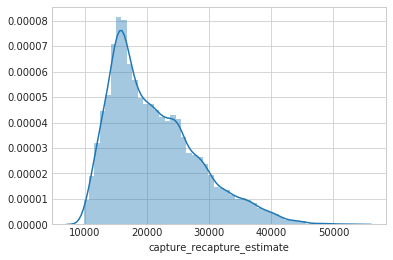

In [13]:
import seaborn as sns

data = lincoln_estimates['capture_recapture_estimate']
sns.distplot(data);

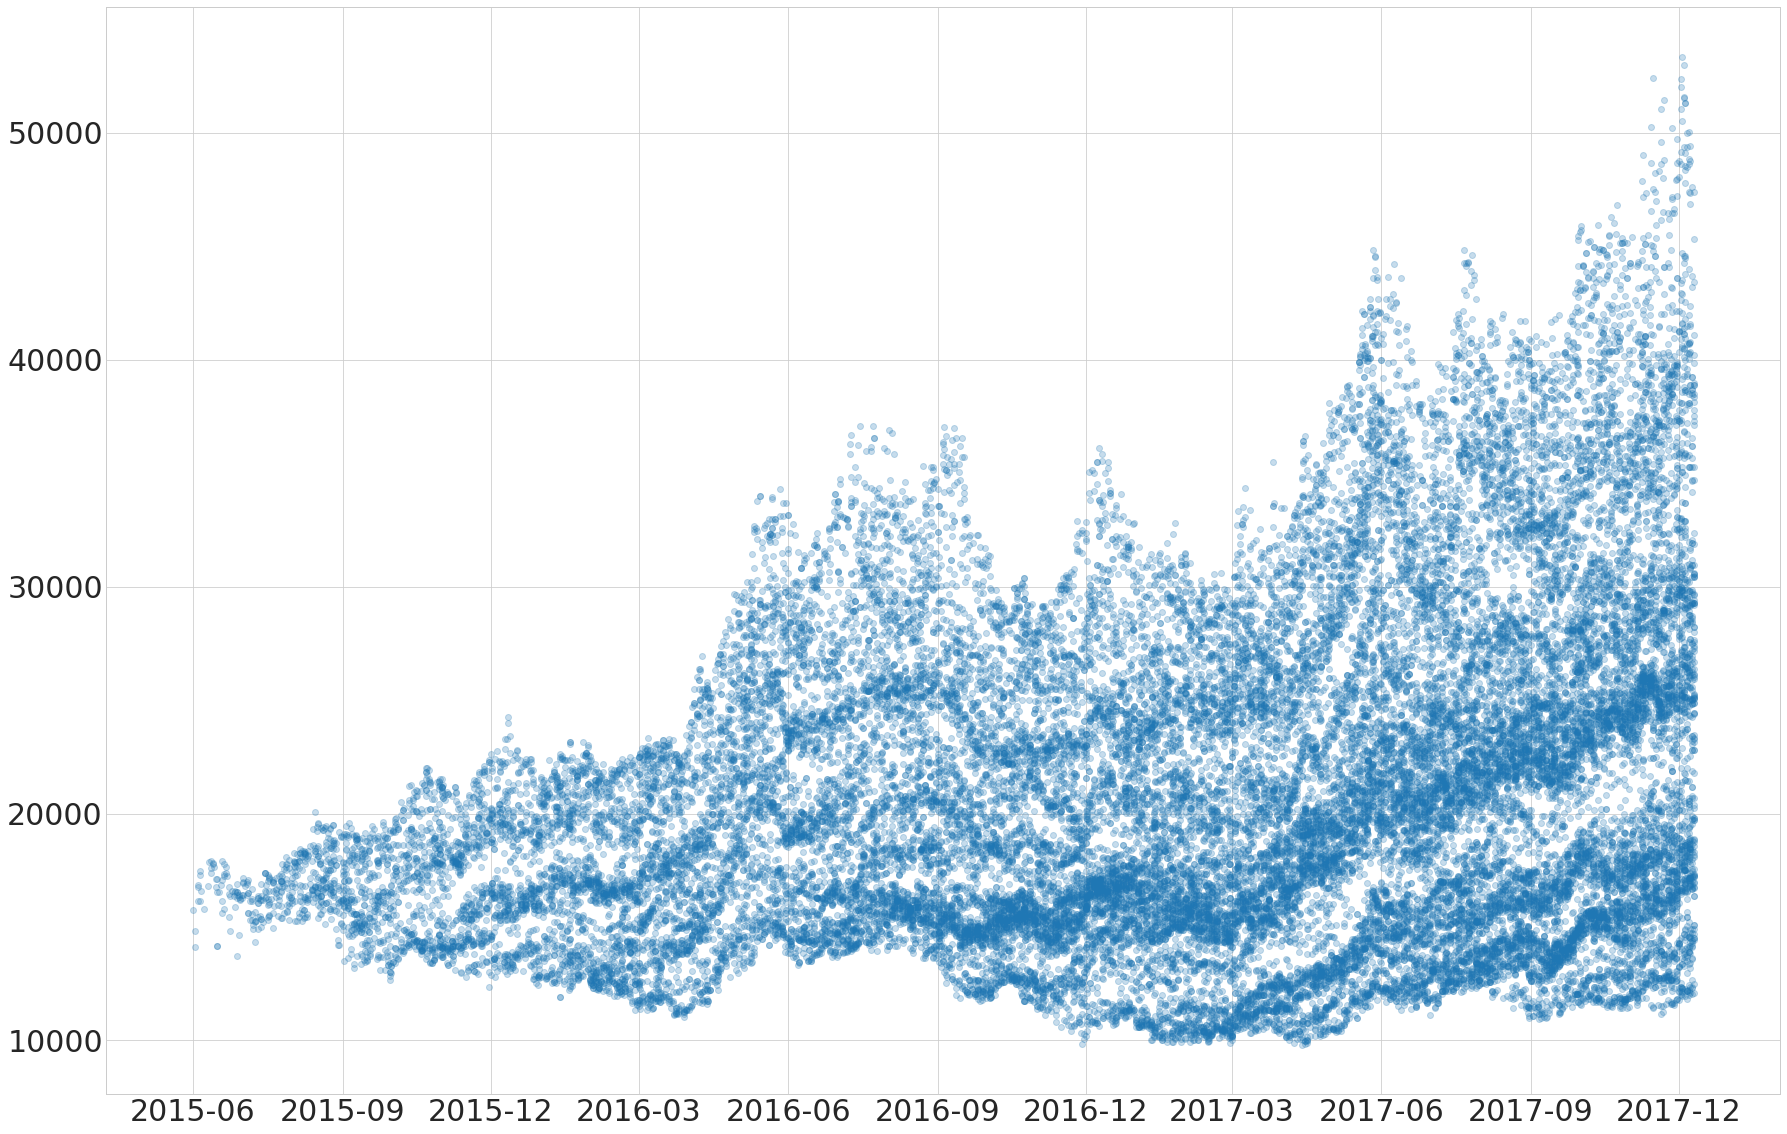

In [14]:
import matplotlib.pyplot as plt

x_axis = lincoln_estimates['groupB_start'].tolist()
y_axis = lincoln_estimates['capture_recapture_estimate'].tolist()

plt.figure(figsize = (30,20))
plt.tick_params(labelsize=30)

plt.scatter(x_axis, y_axis, 
            cmap = plt.cm.coolwarm,
            alpha=0.25)

To make more clear what is going on, let's color the various dots, to make the color proportional to the difference in time between the two sampling periods. Red corresponds to bigger date_diffs, while black corresponds to smaller ones.

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rc("figure", figsize=(16, 8))
mpl.rcParams.update({'font.size': 22})
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
sns.set_style("whitegrid")

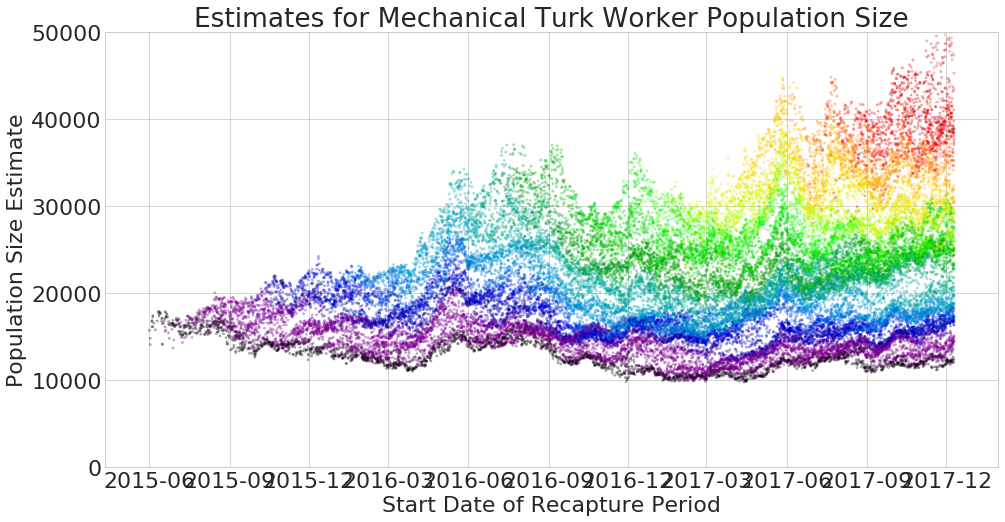

In [16]:
x_axis = lincoln_estimates['groupB_start'].tolist()
y_axis = lincoln_estimates['capture_recapture_estimate'].tolist()
colors = lincoln_estimates['date_diff'].tolist() # / max(lincoln_estimates['date_diff'])

# fig = plt.figure()
fig, ax = plt.subplots(1, 1)  # a figure with a 1x1 "grid" for a single ax (ax = plot)

# ax.tick_params(labelsize=20)
ax.set_title("Estimates for Mechanical Turk Worker Population Size")
ax.set_xlabel("Start Date of Recapture Period")
ax.set_ylabel("Population Size Estimate")
ax.set_ylim([0,50000])

ax.scatter(x_axis, y_axis, 
            c = colors,
            cmap = plt.cm.nipy_spectral,
            s = 4,
            alpha=0.25)

# fig = ax.get_figure()
fig.savefig('plots/lincoln1.pdf', bbox_inches='tight')

Now plotting the same variables, but having the `date_diff` in x-axis, the population estimate on the y-axis, and the color represents the time of the "recapture" period. Red corresponds to resampling periods close to the end of the study, while black corresponds to resampling time periods towards the beginning. Expectedly, we have red-colored dots for a wide variety of date-diff values, while black dots are limited to only a small number of date_diff values, as there were not that many "capture" periods before them.



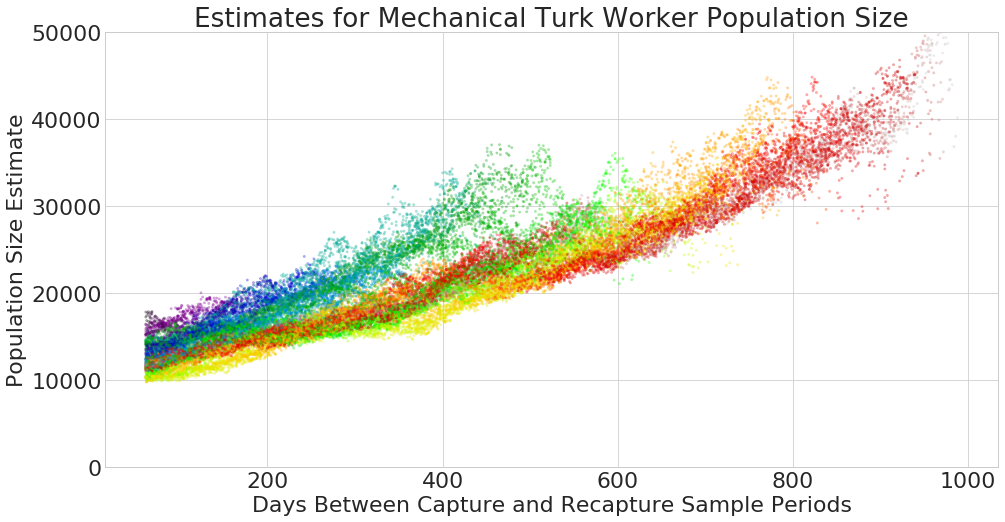

In [17]:
x_axis = lincoln_estimates['date_diff'].tolist()
y_axis = lincoln_estimates['capture_recapture_estimate'].tolist()
colors = lincoln_estimates['groupB_start'].apply(lambda x: (x-minDate).days).tolist() # / max(lincoln_estimates['date_diff'])

# fig = plt.figure()
fig, ax = plt.subplots(1, 1)  # a figure with a 1x1 "grid" for a single ax (ax = plot)

# ax.tick_params(labelsize=20)
ax.set_title("Estimates for Mechanical Turk Worker Population Size")
ax.set_xlabel("Days Between Capture and Recapture Sample Periods")
ax.set_ylabel("Population Size Estimate")
ax.set_ylim([0,50000])

ax.scatter(x_axis, y_axis, 
            c = colors,
            cmap = plt.cm.nipy_spectral,
            s = 4,
            alpha=0.25)

# fig = ax.get_figure()
fig.savefig('plots/lincoln2.pdf', bbox_inches='tight')

If we see the red-colored dots, we see that the population estimates are heavily affected by the date_diff variable. If we compare with sampling periods that are close (i.e small date_diff) then the population estimate is low. If we compare with earlier periods, the estimate is high. This is inconsistent with naive estimator which should not be affected by the time difference between the samples. This indicated the violation of the assumptions. 

Specifically, and expectedly, we expect Turkers to leave the platform. This affects the results, as this leads to a lower number of "marked" workers that we have in later resampling periods. We address the issue next.

The other issue that we will need to address is the issue of selection bias. If some workers are heavily attracted to the survey, this biases the results towards smaller population estimates. (The opposite if workers do not want to participate in  surveys.) We will deal with the issue later.

----------

In [18]:
# Let's plot the same plot as above but using box plots, with the date_diff grouped in groups of 30 days
# group = 30
# lincoln_estimates['date_diff_group'] = lincoln_estimates['date_diff'].apply(lambda x : group*int(round(x/group)))
# lincoln_estimates[['date_diff_group','capture_recapture_estimate']].boxplot(by='date_diff_group', figsize=(15,10))

Our results indicate that the population estimates are increasing as the difference in dates between datasets increases. This is not normal behavior under the ``closed world'' assumption of the Lincoln estimator, indicating that the assumptions of the model are violated. As we will see below, the key problem is the fact that new workers arrive (are "born"), and old workers quit ("die"). Furhtermore, as we have seen earlier, we see that Amazon opened the registration for non-US workers, allowing "immigration" into our area.

### Allowing for departure of workers from the population

Now, we alleviate our assumption of "no departures". We assume that the lifetime of workers in the platform is given by a survival function that has the following form: 

$S(t) = \exp(-\lambda \cdot t)$

with $t$ being the time (in days) since the last survey. In this function, $\lambda$ is the decay rate, which corresponds to the rate in which workers depart from the platform. Notice thatthe parameter  $\lambda$ is assumed to be common across all workers.

Refining the estimator: After the $n_1$ workers are 'marked', there is a $S(t)$ probability that the workers will survive until a resampling period which is $t$ time periods away. On expectation, we will have $S(t) \cdot n_1$ workers in the population during resampling and the probability of picking one one them when picking a random worker is $S(t) \cdot \frac{n_1}{N}$. Therefore when resampling $n_2$ workers, we expect to see on average $E[m] = S(t) \cdot \frac{n_1 \cdot n_2}{N}$ workers.

So, if we capture $m$ workers that have been marked, then the estimate is $N = \exp(-\lambda \cdot t) \cdot \frac{n_1 \cdot n_2}{m}$.


By taking logs: $\ln{N} + \ln{m} = -\lambda \cdot t + \ln{n_1} + \ln{n_2}$

$\lambda \cdot t + \ln{N} + \ln{m} - \ln{n_1} - \ln{n_2} = 0$

$\beta_1 \cdot x_1 + \beta_0  = y$

* $\beta_1 = \lambda$
* $x_1 = t$
* $\beta_0=\ln{N}$ 
* $y = \ln{n_1} + \ln{n_2} - \ln{m}$

This approach assumes that the population $N$ remains the same. When we allow $N$ to vary per sampling period, we add a fixed-effect / categorical variable for the beginning of the recapture group, :

* $\beta_1 = \lambda$
* $x_1 = t$
* $\beta_0 + \beta_{date} = \ln{N \cdot c(date)} =  \ln{N} + \ln{c(date)}$ 
* $y = \ln{n_1} + \ln{n_2} - \ln{m}$

with $c(date)$ being a binary variable, that gets assigned a coefficient that is a multiplier of the average population $N$.

So the population on _date_ is $N \cdot c(date) = \exp(\beta_0 + \beta_{date}) = \exp(\beta_0) * \exp(\beta_{date})$

In [19]:
# Assuming an exponential survival function S(t) = K * exp(-lambda * t)
import math
import statsmodels.formula.api as sm
from datetime import datetime

def fit_survival(data):
    result = sm.ols(formula="y ~ date_diff + C(groupB_start)", data=data).fit()
    #print(result.summary())
    fit_N = math.exp(result.params['Intercept']) #average population, exp(beta_0)
    N_d = [{"date": datetime.strptime(d[29:-12], '%Y-%m-%d') , "population": fit_N * math.exp(result.params[d])} 
        for d in result.params.index 
        if d.startswith('C(groupB_start)')]
    #N_err = result.bse['Intercept']
    #N_low = math.exp(result.params['Intercept'] +N_err)
    #N_high = math.exp(result.params['Intercept'] -N_err)
    fit_lambda = result.params['date_diff']
    #lambda_err = result.bse['date_diff']
    return {
        'N': fit_N,
        'N_d': N_d,
        'lambda': fit_lambda,
        'half-life': math.log(2)/fit_lambda,
    }

results = fit_survival(lincoln_estimates)

In [20]:
print_outcome = dict(results)
del print_outcome['N_d']
print(print_outcome)

{'N': 14283.41919884187, 'lambda': 0.0015397586612688177, 'half-life': 450.1661188830505}


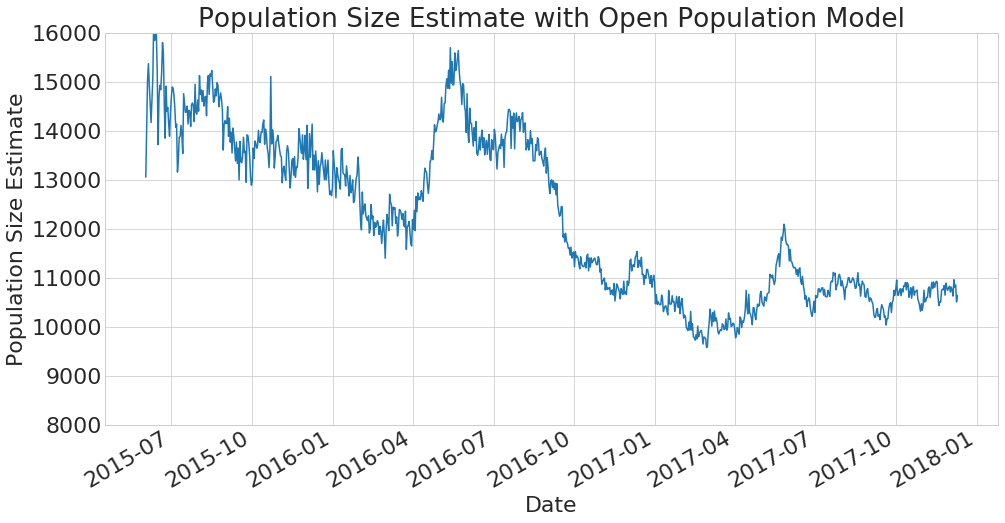

In [21]:
# fig = plt.figure()
fig, axes = plt.subplots(1, 1)  # a figure with a 1x1 "grid" for a single ax (ax = plot)

ax = pd.DataFrame(results['N_d']).set_index('date').sort_index().plot(ax=axes)
ax.set_title("Population Size Estimate with Open Population Model")
ax.set_xlabel("Date")
ax.set_ylabel("Population Size Estimate")
ax.set_ylim([8000,16000])
ax.legend().set_visible(False)

fig.savefig('plots/openpopulation.pdf', bbox_inches='tight')